In [1]:
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
import plotly as ply
import plotly.express as px
import numpy as np
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pylab import rcParams
from helper_functions import load_data, get_data4uid



Using TensorFlow backend.
C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Tools\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be 

In [2]:
rcParams['figure.figsize'] = (15, 8)
# Load data
prices_pd, stations_pd = load_data('./Data/prices_40.sql')

### Forecast model

All libraries and data was loaded before, here i want to build a forecast model for fuel prices.
First I'll we have a closer look to the data with the statsmodel package. 


In [3]:
star_bahn = get_data4uid(prices_pd, '005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel')

In [4]:
star_bahn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22543 entries, 2015-01-01 08:50:01+00:00 to 2019-12-20 22:03:03+00:00
Data columns (total 1 columns):
diesel    22218 non-null float64
dtypes: float64(1)
memory usage: 352.2 KB


In [5]:
# i want to use daily values for the ongoing analysis

star_bahn.dropna(inplace=True)
star_day = star_bahn.resample('d').mean()


In [6]:
star_day = star_day.asfreq('d')
star_day.dropna(inplace=True)

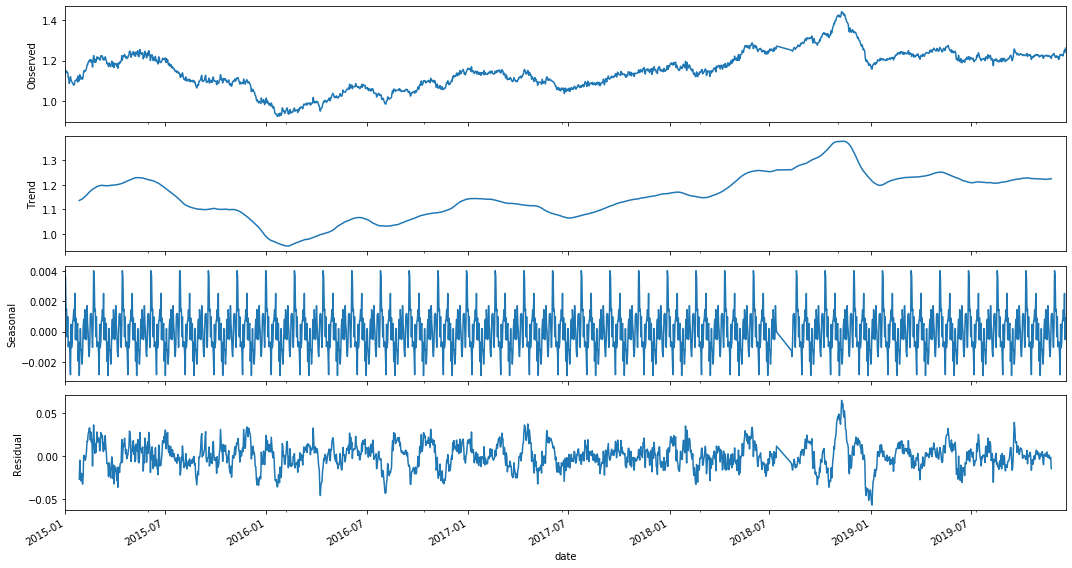

In [7]:
# let's see what is in the data, let assume a weekly seasonal
decompostion = sm.tsa.seasonal_decompose(star_day, freq=52, model='additive')
decompostion.plot();

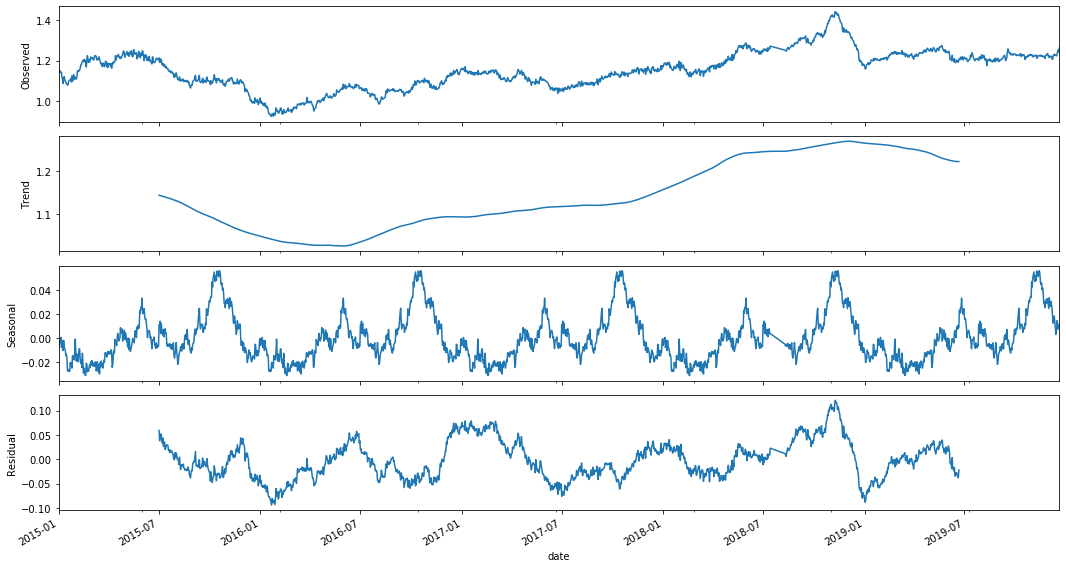

In [8]:
# now let's see if we a yearly seasonal aspect inside
decompostion = sm.tsa.seasonal_decompose(star_day, freq=365, model='additive')
decompostion.plot();

### Trend and Saisonality

In the above plots you can easily see, there is a trend and a seasonal aspect in the data. In the first plot you'll see the weekly seasonal aspects and in the second plot you can also see a yearly seasonal aspect in the diesel price.
Therefore a standard ARIMA model will have problems with such data, even the SARIMA model, because the data is not stationary.

The stationarity can be forced with the difference, let's see...

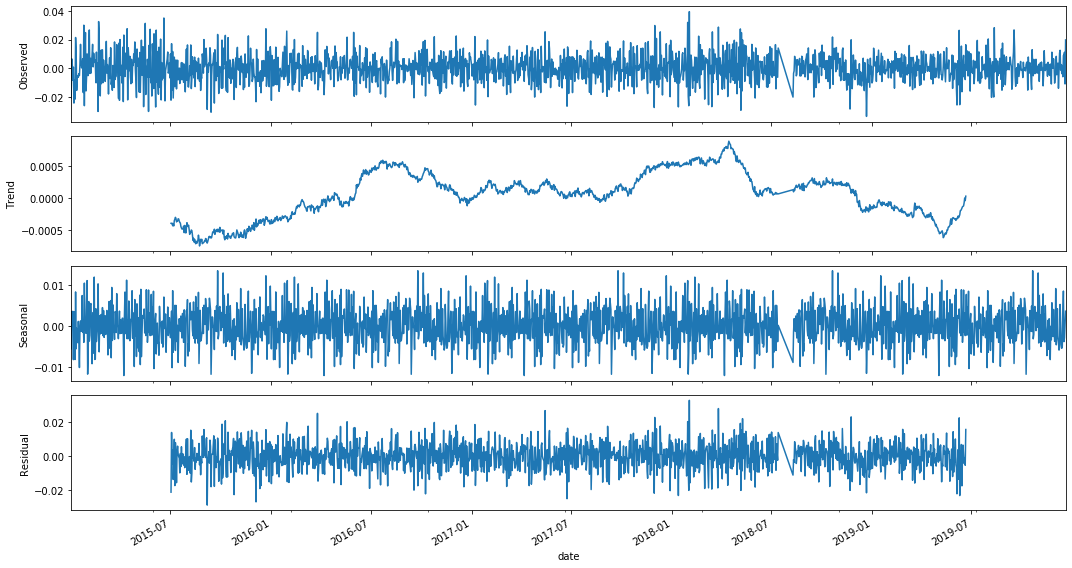

In [9]:
decompostion = sm.tsa.seasonal_decompose(star_day.diff().dropna(), freq=365, model='additive')
decompostion.plot();

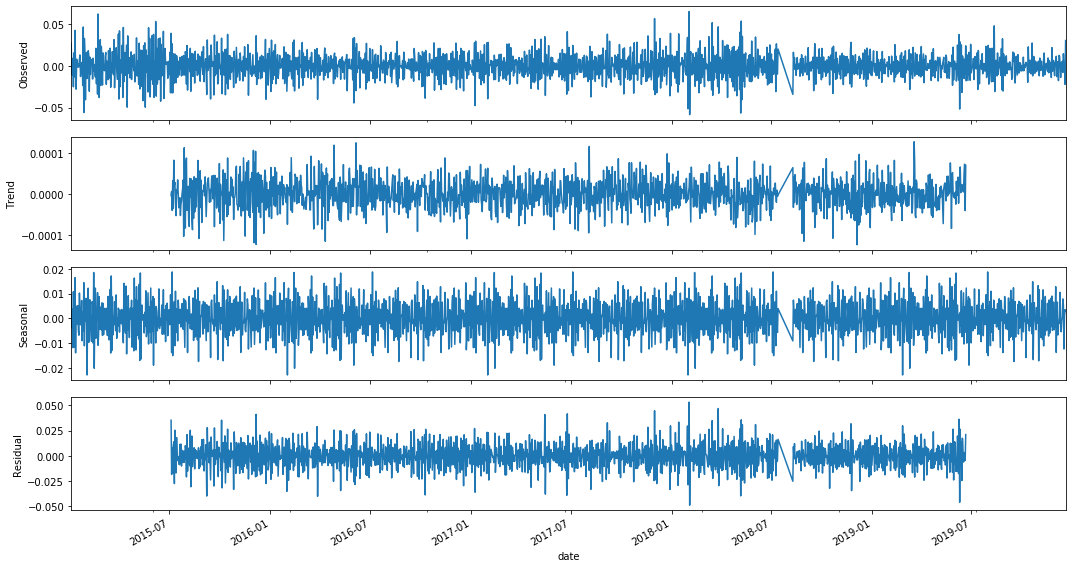

In [10]:
decompostion = sm.tsa.seasonal_decompose(star_day.diff().dropna().diff().dropna(), freq=365, model='additive')
decompostion.plot();

Even in the first difference there is a small trend, it is removed when we diff a second time.

#### ACF/PACF
Let's see if it is also seen in ACF and PACF.

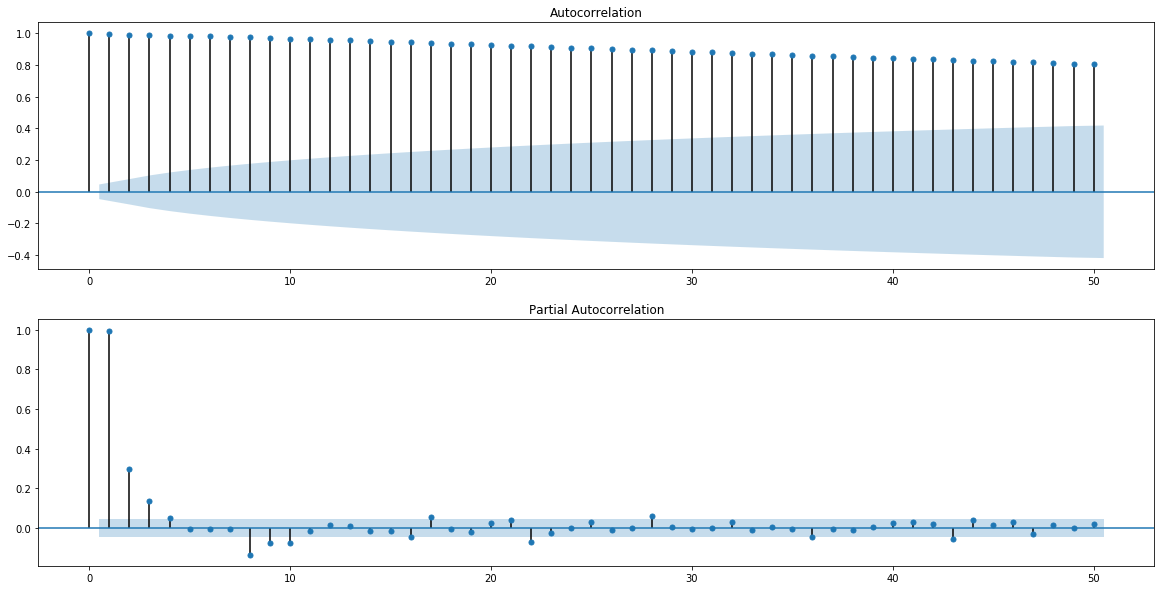

In [11]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.dropna(), lags=50, ax=ax[1])
plt.show()

So from the ACF there is also clearly, that the raw data is not stationary. Let's see hte ACF and PACF for the first difference.

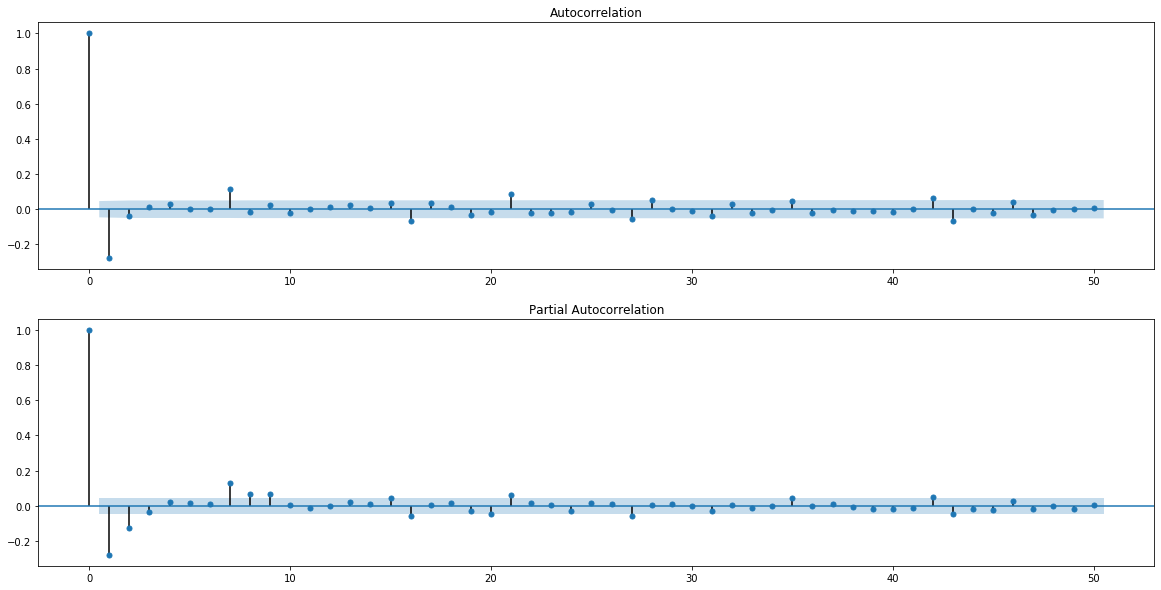

In [12]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.diff().dropna(), lags=50, ax=ax[1])
plt.show()

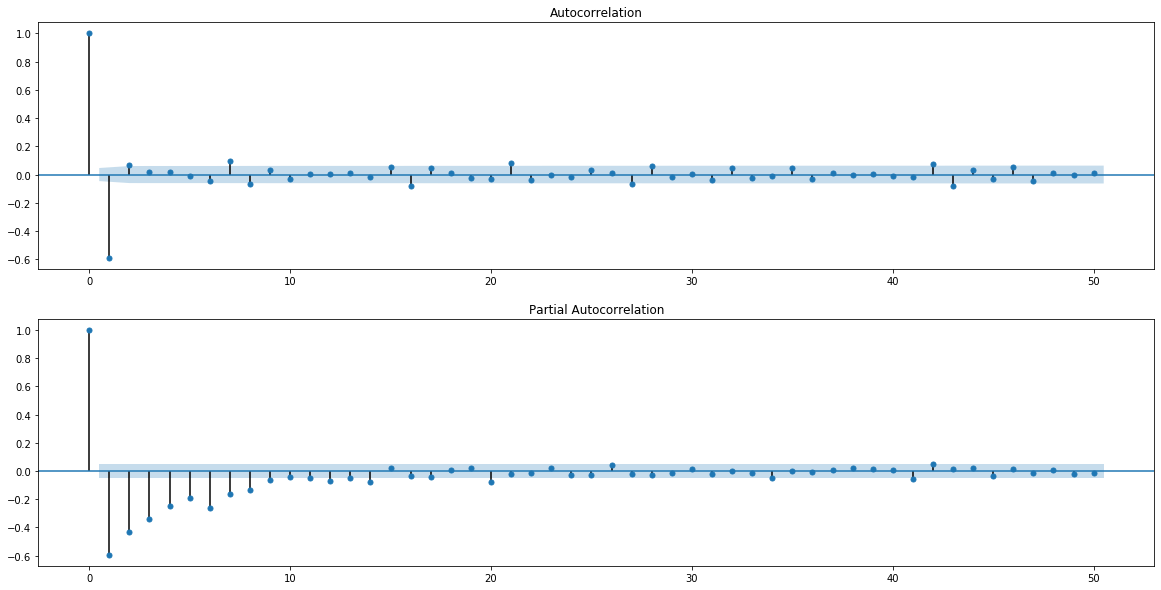

In [13]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.diff().dropna().diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.diff().dropna().diff().dropna(), lags=50, ax=ax[1])
plt.show()

Here is the same result, the original data is not stationary, seen in the Autocorrelation part. But the first difference seems to be also good, so it could be, that we can also use the first difference. Let's see what the ADF and KPSS test will bring.

In [14]:
# found this summary for all values of Adfuller and KPSS test usefull and therefore 
def stationarity_test(ts):
    print('Results of ADF Test:')
    df = sm.tsa.adfuller(ts, autolag='AIC')
    df_out = pd.Series(df[0:4], index = ['Test statistics', 'p-value', 'Number of lags', '#Observations'])
    for key,value in df[4].items():
        df_out['Critical Value (%s)'%key] = value
    print(df_out)
    
#When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, lags='auto', regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
#If the test statistic is greater than the critical value,  (series is not stationary)


In [15]:
stationarity_test(star_day.diesel.dropna())
kpss_test(star_day.diesel.dropna())

Results of ADF Test:
Test statistics           -1.755519
p-value                    0.402758
Number of lags             9.000000
#Observations           1779.000000
Critical Value (1%)       -3.434031
Critical Value (5%)       -2.863166
Critical Value (10%)      -2.567636
dtype: float64
Results of KPSS Test:
Test Statistic            2.994083
p-value                   0.010000
Lags Used                27.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning:

p-value is smaller than the indicated p-value



In [16]:
stationarity_test(star_day.diesel.diff().dropna())
kpss_test(star_day.diesel.diff().dropna())

Results of ADF Test:
Test statistics        -1.170910e+01
p-value                 1.503941e-21
Number of lags          8.000000e+00
#Observations           1.779000e+03
Critical Value (1%)    -3.434031e+00
Critical Value (5%)    -2.863166e+00
Critical Value (10%)   -2.567636e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.099407
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning:

p-value is greater than the indicated p-value



In [17]:
stationarity_test(star_day.diesel.diff().dropna().diff().dropna())
#kpss_test(star_day.diesel.diff().dropna().diff().dropna())
#I cannot say, why hte KPSS Test run in error for the second difference. It seems to be an implementation error? Therefore i commented it here

Results of ADF Test:
Test statistics        -1.369992e+01
p-value                 1.295537e-25
Number of lags          2.400000e+01
#Observations           1.762000e+03
Critical Value (1%)    -3.434067e+00
Critical Value (5%)    -2.863182e+00
Critical Value (10%)   -2.567644e+00
dtype: float64


The Adfuller and KPSS test for the first difference is also ok, means the first difference is stationary. So we can use d=1 for the ARIMA model.
### ARIMA model

In [18]:
# split train and test data
train = star_day['2015-01-01':'2018-12-31'].diesel
test = star_day['2019-01-01':].diesel
train = train.tz_localize(None)
test = test.tz_localize(None)

In [19]:
#first try training with d=1 only
model = sm.tsa.statespace.SARIMAX(endog=train, order=(3,1,1), seasonal_order=(3,1,1,52), enforce_invertibility=False)
results = model.fit()

C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             diesel   No. Observations:                 1435
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 52)   Log Likelihood                4262.223
Date:                            Mon, 23 Dec 2019   AIC                          -8506.446
Time:                                    19:10:28   BIC                          -8459.365
Sample:                                         0   HQIC                         -8488.835
                                           - 1435                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1478      2.866     -0.052      0.959      -5.766       5.470
ar.L2         -0.0598      0.912     -0.066      0.948      -1.848       1.728
ar.L3          0.0101      0.323      0.031      0.975      -0.623       0.644
ma.L1         -0.1705      2.863     -0.060      0.953      -5.782       5.441
ar.S.L52      -0.8550      0.113     -7.587      0.000      -1.076      -0.634
ar.S.L104     -0.6034      0.080     -7.565      0.000      -0.760      -0.447
ar.S.L156     -0.2871      0.050     -5.752      0.000      -0.385      -0.189
ma.S.L52       0.0820      0.120      0.683      0.495      -0.153       0.317
sigma2         0.0001   4.22e-06     28.170      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       83.38   Jarque-Bera (JB):                13.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.08
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

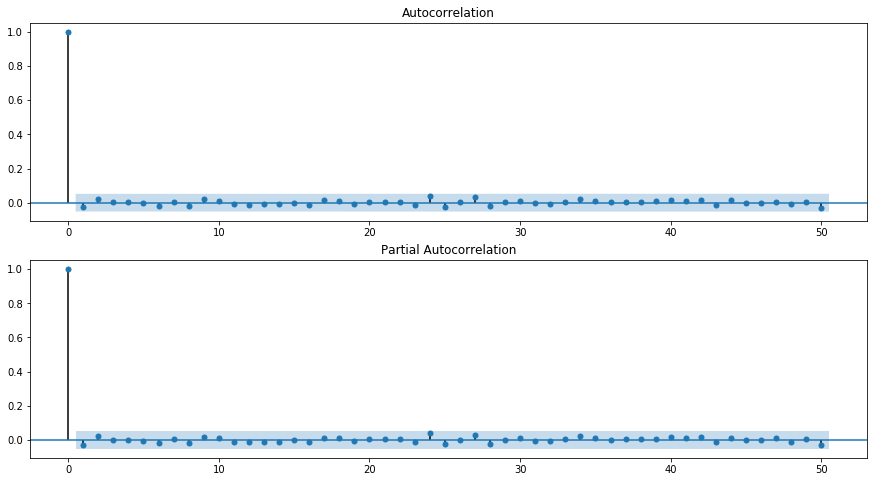

In [21]:
resid = results.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(resid, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(resid, lags=50, ax=ax[1])

In [22]:
pred = results.forecast(steps=354)

C:\Tools\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [23]:
print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred)))

ARIMA model MSE:0.028432350988555427


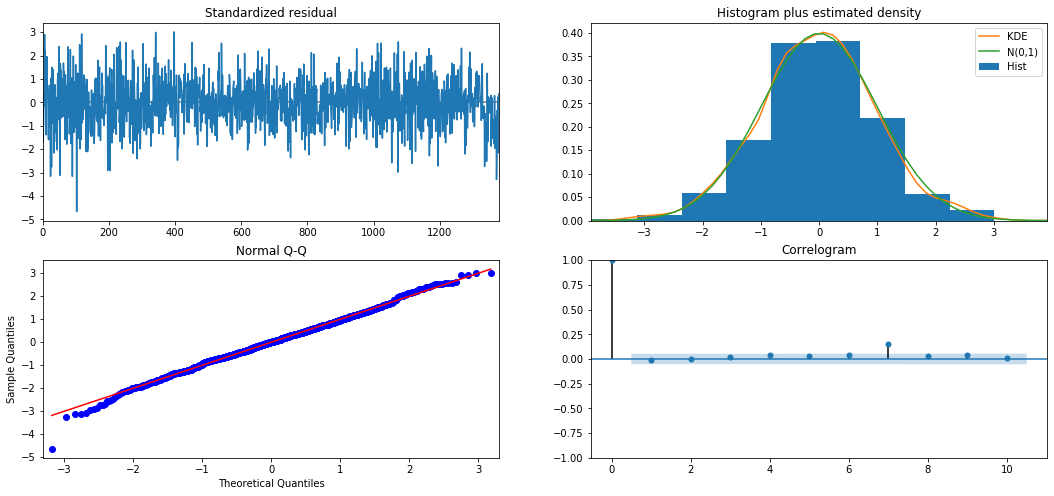

In [24]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

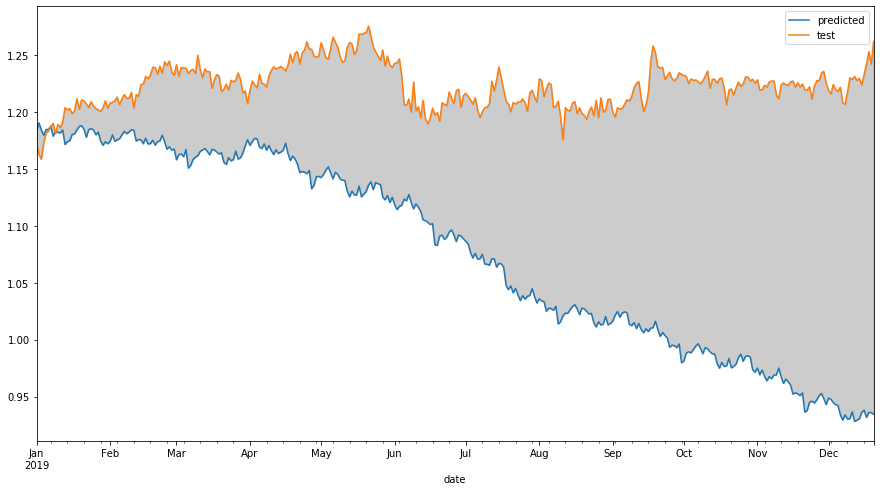

In [25]:
pred.index = test.index
pred.plot(label='predicted')
test.plot(label='test')
plt.fill_between(pred.index,
                pred,
                test, color='k', alpha=.2)

plt.legend();

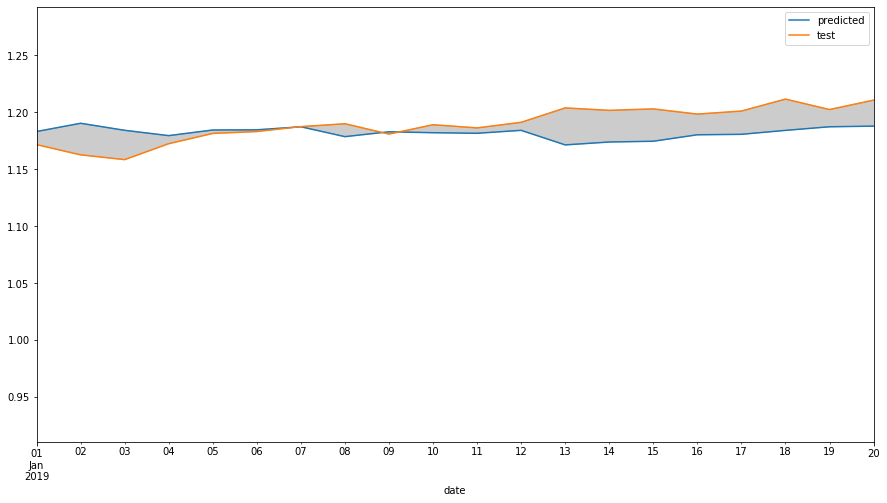

In [26]:
pred[:'2019-01-20'].plot(label='predicted')
test[:'2019-01-20'].plot(label='test')
plt.fill_between(pred.index,
                pred,
                test, color='k', alpha=.2)

plt.legend();

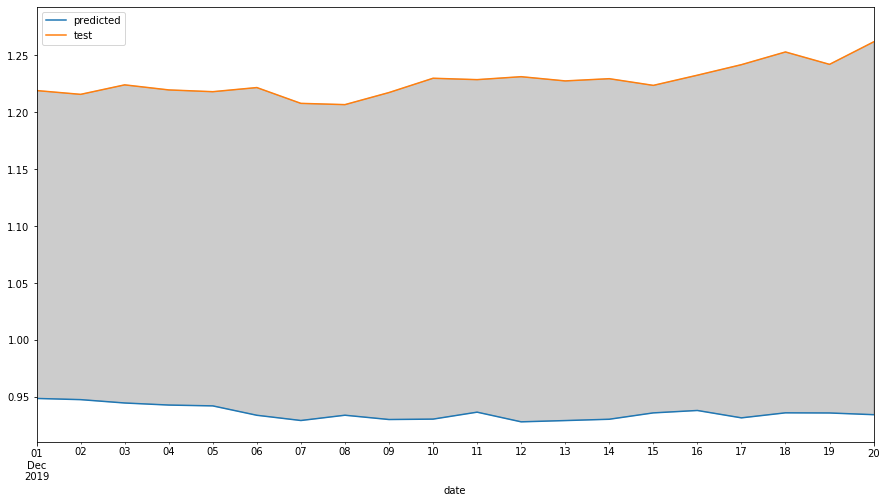

In [27]:
pred['2019-12-01':'2019-12-20'].plot(label='predicted')
test['2019-12-01':'2019-12-20'].plot(label='test')
plt.fill_between(pred.index,
                pred,
                test, color='k', alpha=.2)

plt.legend();

### Not Bad but also not good
The ARIMA model is not bad and the predictions in the first days are not so far away from the real values, but if we have look at the end of the test data, we have big differences.

### LSTM

I will now try to build a LSTM model for prediction. Therefore i will scale the input and divide in three sets: train, validation and test data.

In [28]:
# the values have to be normalized for LSTM
values = star_day['diesel'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [29]:
# use the same data for trainine up to 2018
train_size = len(star_day[:'2018-12-31'])
vali_size = 31 # let's take 1 month as validation set for fitting
test_size = len(scaled) - train_size
train, vali, test = scaled[:train_size,:], scaled[train_size:train_size+vali_size,:], scaled[train_size+vali_size:, :]
print(len(train), len(vali), len(test))

1435 31 323


In [30]:
def create_data(dataset, look_back=1):
    '''creates two array of x and y out of the given array
    Input: Array of data, steps to look back
    Output: X, Y
    '''
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)



In [31]:
look_back = 2
trainX, trainY = create_data(train, look_back)
valiX, valiY = create_data(vali, look_back)
testX, testY = create_data(test, look_back)

1433
29
321


In [32]:
# reshape to make it usable as input for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valiX = np.reshape(valiX, (valiX.shape[0], 1, valiX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [33]:
# build a LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(valiX, valiY), verbose=0, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


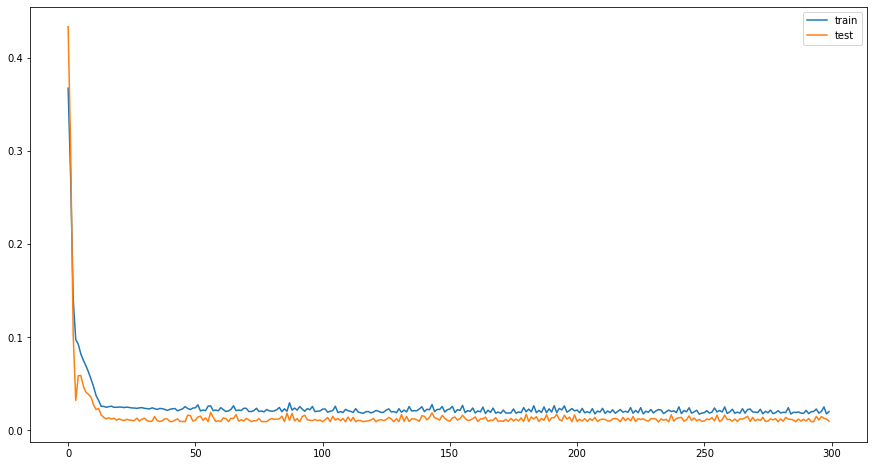

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [35]:
history.params

{'batch_size': 100,
 'epochs': 300,
 'steps': None,
 'samples': 1433,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'val_loss']}

In [36]:
# make predictions
train_pre = model.predict(trainX)
test_pre = model.predict(testX)
# invert predictions
train_pre = scaler.inverse_transform(train_pre)
trainY = scaler.inverse_transform([trainY])
test_pre = scaler.inverse_transform(test_pre)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], train_pre[:,0]))
print('Train Score: %.4f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], test_pre[:,0]))
print('Test Score: %.4f RMSE' % (testScore))


Train Score: 0.0108 RMSE
Test Score: 0.0088 RMSE


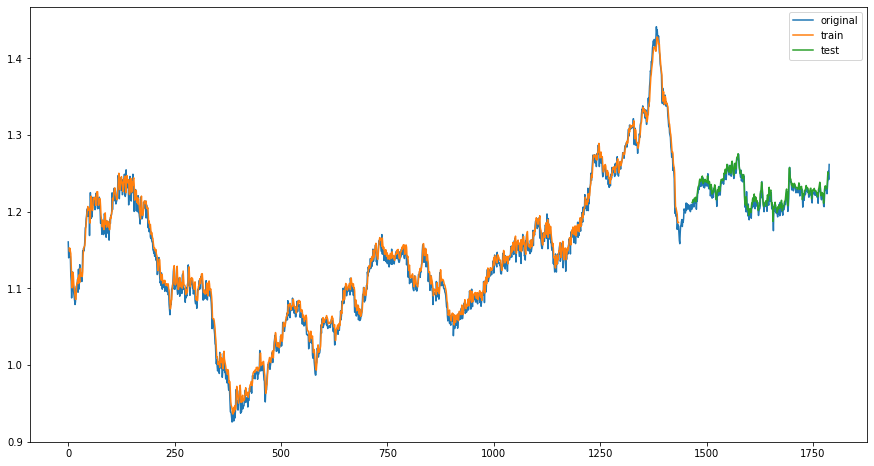

In [37]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pre)+look_back, :] = train_pre
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pre)+vali_size+(look_back*2)-2:len(scaled)-2, :] = test_pre
# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['original', 'train', 'test'])
plt.show()

### Good prediction?!?
In the first view the prediction of the test data on the right side in green seems to be very similar to the original data. We will have a closer look inside.

In [38]:
# make a dataframe of the predictions and set index, the test data starts val_size + lookback
test_pre_pd = pd.DataFrame(test_pre)
test_pre_pd.index = star_day['2019-02-03':'2019-12-20'].index


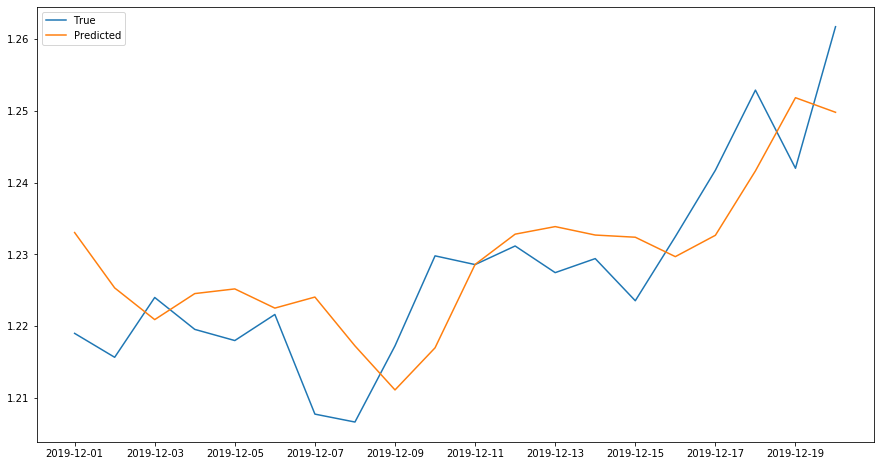

In [39]:
# let's have a closer look at the test data
plt.plot(star_day['2019-12-01':'2019-12-20'], label='True')
plt.plot(test_pre_pd['2019-12-01':'2019-12-20'], label='Predicted')
plt.legend();

Here we can see, that the prediction is more a follower than a prediction, what is really good to see in the above plot.



# Conclusion and lookout
I'll used the diesel price data freely available from [Tankerkoenig](www.tankerkoenig.de) to make a daily forecast of the diesel price. Therefore i first load the data ([DataRead.ipynb](./DataAnalysis.ipynb)) and extract only some data out of the zip code area of 40xxx. 
The raw data showed trend and seasonality and was not stationary. So i used difference for ARIMA to have stationarity. The ARIMA model has problems with this data. On the test set you saw that the prediction after a few days differ from the original data.
One possibility to get ARIMA better is to use other parameter for p, d, q. For example to use d=2, but in my tests the calculation time exhausted. Therefore i left it to the above model.

Then i've looked in LSTM as model, the training was really fast and the first view on the test data set was promising. If you have a closer look, you see the predictions are "following", so it could be, that a prediction for next day is not so good.
Here we have the possibility to take more lookbacks in account or to choose another model to get better predictions.

